# Exploratory Data Analysis

In the following, I analyze the dataset underlying the ML model for scheduling standby drivers.
<br>
I want to clarify which variables are interrelated, how they are distributed and thus find out which ones are suitable for the model as features.

#### Fragen?
* Are the data seasonal?
* What is the connection between how many standby drivers are needed?
* Frage 3

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import pearsonr
import statsmodels.api as sm

### Load and inspect the data:

In [2]:
df = pd.read_csv('/Users/kata/Desktop/GitHub/standby_duty_forecasting/sickness_table.csv') #, index_col=0)

In [3]:
df.head()

,Unnamed: 0,date,n_sick,calls,n_duty,n_sby,sby_need,dafted
0,0,2016-04-01,73,8154.0,1700,90,4.0,0.0
1,1,2016-04-02,64,8526.0,1700,90,70.0,0.0
2,2,2016-04-03,68,8088.0,1700,90,0.0,0.0
3,3,2016-04-04,71,7044.0,1700,90,0.0,0.0
4,4,2016-04-05,63,7236.0,1700,90,0.0,0.0


* **date:** entry date
* **n_sick:** number of drivers called sick on duty
* **calls:** number of emergency calls
* **n_duty:** number of drivers on duty available
* **n_sby:** number of standby resources available
* **sby_need:** number of standbys, which are activated on a given day
* **dafted:** number of additional drivers needed due to not enough standbys

Let's look at numerical summaries:

In [4]:
df.describe(include = 'all')

,Unnamed: 0,date,n_sick,calls,n_duty,n_sby,sby_need,dafted
count,1152.000000,1152,1152.000000,1152.000000,1152.000000,1152.0,1152.000000,1152.000000
unique,NaN,1152,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,2018-10-09,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN
mean,575.500000,NaN,68.808160,7919.531250,1820.572917,90.0,34.718750,16.335938
std,332.698061,NaN,14.293942,1290.063571,80.086953,0.0,79.694251,53.394089
min,0.000000,NaN,36.000000,4074.000000,1700.000000,90.0,0.000000,0.000000
25%,287.750000,NaN,58.000000,6978.000000,1800.000000,90.0,0.000000,0.000000
50%,575.500000,NaN,68.000000,7932.000000,1800.000000,90.0,0.000000,0.000000
75%,863.250000,NaN,78.000000,8827.500000,1900.000000,90.0,12.250000,0.000000


Check for NaN-values:

In [5]:
df[df.isnull().any(axis=1)]

,Unnamed: 0,date,n_sick,calls,n_duty,n_sby,sby_need,dafted


The following data types exist:

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1152 entries, 0 to 1151
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  1152 non-null   int64  
 1   date        1152 non-null   object 
 2   n_sick      1152 non-null   int64  
 3   calls       1152 non-null   float64
 4   n_duty      1152 non-null   int64  
 5   n_sby       1152 non-null   int64  
 6   sby_need    1152 non-null   float64
 7   dafted      1152 non-null   float64
dtypes: float64(3), int64(4), object(1)
memory usage: 72.1+ KB


So sehen die Were in verschiedenen Spalten aus:

In [7]:
df.n_duty.unique()

array([1700, 1800, 1900])

This means, there is only three options of drivers on duty. The values increase over time.

In [8]:
df.n_sby.unique()

array([90])

There are always 90 drivers on standby.

In [9]:
print(df.date.min())
print(df.date.max())

2016-04-01
2019-05-27


The data covers a period of three years, from April 1st 2016 to May 27th 2019.

In [10]:
print(df.calls.min())
print(df.calls.max())
print(df.calls.mean())

4074.0
11850.0
7919.53125


At least 4074 calls were received during the period, maximum 11.850. On average, 7919.53 calls were received.

In [11]:
print(df.sby_need.min())
print(df.sby_need.max())
print(df.sby_need.mean())

0.0
555.0
34.71875


On average, 34.7 drivers are needed on standby. However, since the maximum is 555, it is worth looking for outliers here.

Correlation matrix between all the features we are examining and our y-variable:

In [12]:
corr = df.corr()

print(corr)

            Unnamed: 0    n_sick     calls    n_duty  n_sby  sby_need  \
Unnamed: 0    1.000000  0.495959  0.385679  0.927437    NaN  0.137543   
n_sick        0.495959  1.000000  0.155371  0.459501    NaN  0.022321   
calls         0.385679  0.155371  1.000000  0.364135    NaN  0.677468   
n_duty        0.927437  0.459501  0.364135  1.000000    NaN  0.090654   
n_sby              NaN       NaN       NaN       NaN    NaN       NaN   
sby_need      0.137543  0.022321  0.677468  0.090654    NaN  1.000000   
dafted        0.131938  0.016800  0.557340  0.084955    NaN  0.945168   

              dafted  
Unnamed: 0  0.131938  
n_sick      0.016800  
calls       0.557340  
n_duty      0.084955  
n_sby            NaN  
sby_need    0.945168  
dafted      1.000000  


### Investigate graphically

Make pairplots to investigate data further and spot correlations:

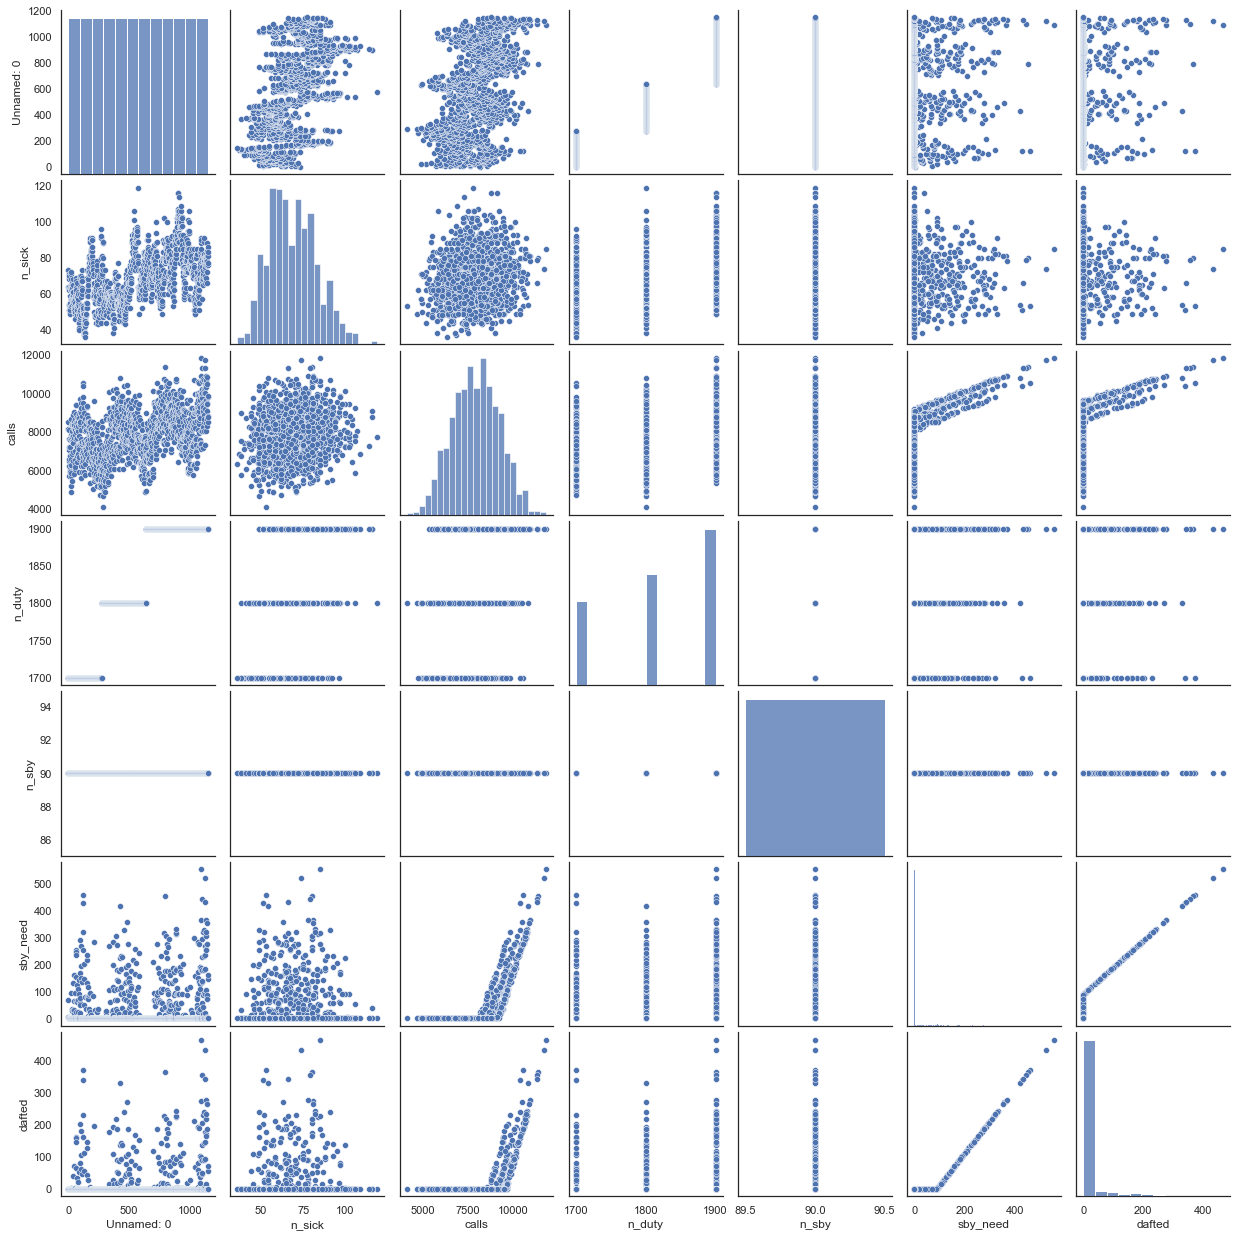

In [13]:
sns.set_theme(style="white")

sns.pairplot(df)

n_sick und calls sind saisonal, bei sby_need und calls sieht man, dass es erst ab 8000 calls Standby-Fahrer braucht.

The distribution of "sby_need" looks interesting, this is how the histogram looks in detail:

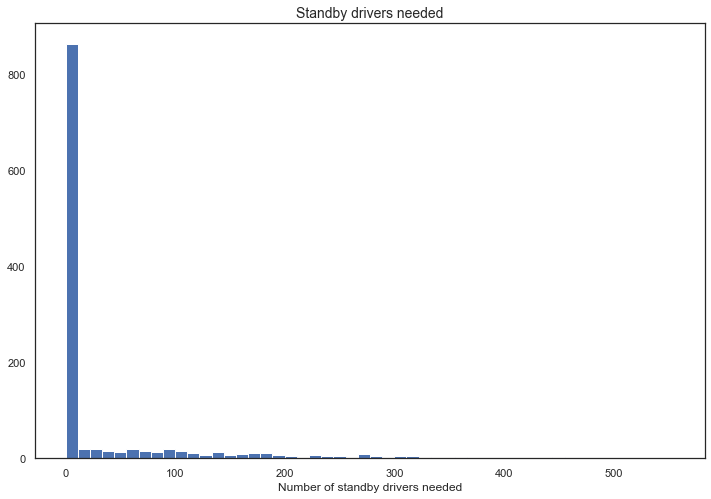

In [14]:
plt.figure(figsize=(12, 8))
plt.clf()
plt.hist(df.sby_need, bins=50)
plt.title('Standby drivers needed', fontsize=14)
plt.xlabel('Number of standby drivers needed')
plt.show()

In [15]:
new_df2 = df.groupby(['sby_need']).size()
print(new_df2)

sby_need
0.0      849
2.0        3
4.0        4
5.0        1
6.0        2
        ... 
445.0      1
454.0      1
461.0      1
523.0      1
555.0      1
Length: 185, dtype: int64


Standby drivers were not needed in nearly three-quarters of the cases. However, there are also individual cases in which several hundred were needed.
<br>
Another graphic will illustrate this.

<Figure size 432x288 with 0 Axes>

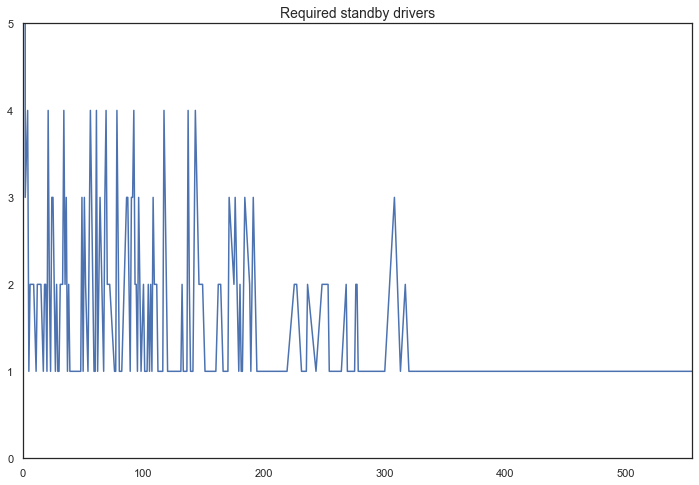

In [16]:
# needed???
plt.clf()
plt.figure(figsize=(12, 8))
plt.plot(new_df2)
plt.axis([0, 555, 0, 5])
plt.title('Required standby drivers', fontsize=14)
plt.show()

Most of the time no standby drivers were needed, otherwise between 2 and 5. It could become problematic that there are numerous individual cases where hundreds were needed.

Visualize data over the years:

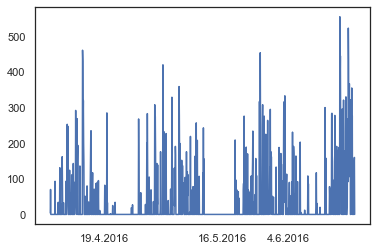

In [17]:
plt.plot(df.date, df.sby_need)
plt.xticks([204, 650, 900], ['19.4.2016', '16.5.2016', '4.6.2016'])
plt.show()

### Further Correlations

We observe that the number of drivers increases over the years. Is there a correlation with the number of calls?

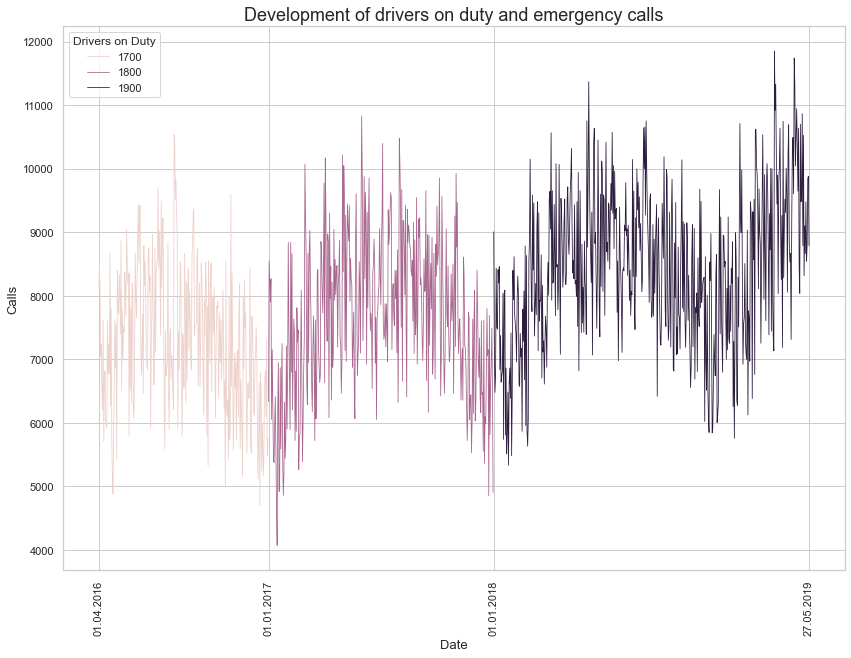

In [18]:
plt.figure(figsize=(14,10))
sns.set_style("whitegrid")
sns.lineplot(x='date', y='calls', hue='n_duty', data=df, linewidth = 0.8)
plt.xticks([0, 275, 640, 1151], ['01.04.2016', '01.01.2017', '01.01.2018', '27.05.2019'])
plt.xticks(rotation=90)

plt.legend(labels=["1700","1800", "1900"], title = "Drivers on Duty")
plt.xlabel('Date', fontsize=13)
plt.ylabel('Calls', fontsize=13)
plt.title('Development of drivers on duty and emergency calls', fontsize=18)

plt.savefig("dev_n_duty_calls.svg")
plt.show()

The graph shows that the number of drivers on duty increases with the number of calls.

In [19]:
print(pearsonr(df.calls, df.n_duty)[0])

0.36413536110780714


According to Pearson's correlation coefficient r, the two variables are slightly positively correlated with a value of 0.36.

What about the number of calls and the number of drivers on sick leave?

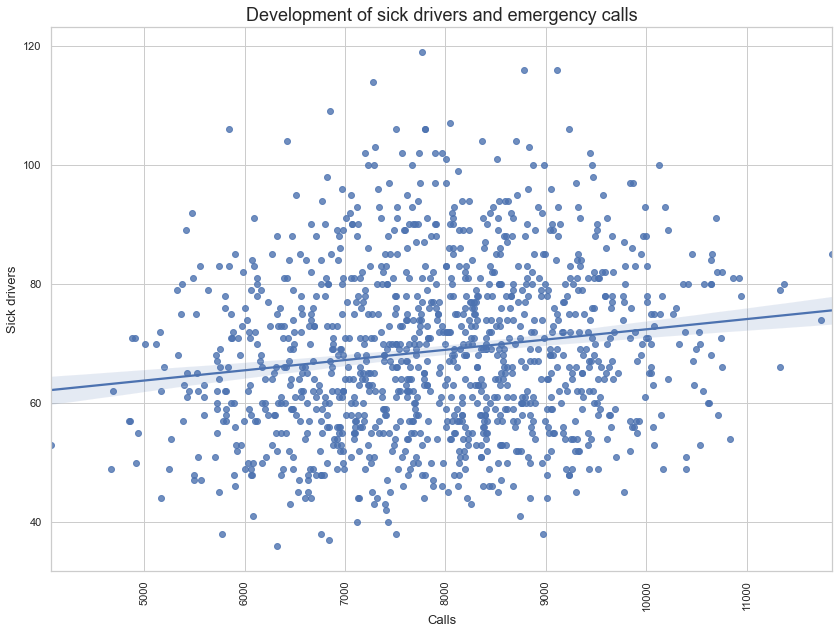

In [20]:
plt.figure(figsize=(14,10))
sns.set_style("whitegrid")
sns.regplot(x='calls', y='n_sick', data=df)
plt.xticks(rotation=90)

plt.title('Development of sick drivers and emergency calls', fontsize=18)
plt.xlabel('Calls', fontsize=13)
plt.ylabel('Sick drivers', fontsize=13)

plt.show()

If the number of calls increases, the number of sick drivers slightly increases

In [21]:
print(pearsonr(df.calls, df.n_sick)[0])

0.15537086860280808


The variables are weakly positively correlated.

The pairplot above suggests a correlation between calls and drivers needed. Pearson's r confirms this:

In [22]:
print(pearsonr(df.calls, df.sby_need)[0])

0.677467517263761


The variables "n_sick" and "sby_need" are less related than thought:

In [23]:
print(pearsonr(df.n_sick, df.sby_need)[0])

0.022321406858650947


Check seasonality:

<Figure size 1440x1008 with 0 Axes>

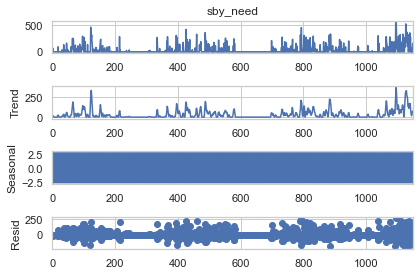

In [28]:
# split variable into components to see seasonal variation



res = sm.tsa.seasonal_decompose(df.sby_need, period=4)
plt.figure(figsize=(20,14))
res.plot()
plt.savefig("seasonal.svg")
plt.show()

In [25]:
type(dta)

NameError: name 'dta' is not defined